In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from sklearn.cluster import MeanShift

In [3]:
#ass1的方法
def max_filter(img,N,m):
    imgA=np.zeros_like(img)
    #imgA=img.copy()
    padding_img=cv2.copyMakeBorder(img,m,m,m,m,cv2.BORDER_CONSTANT)
    for r in range(img.shape[0]):
        for c in range(img.shape[1]):
            new=padding_img[r:r+N,c:c+N].copy()
            #new=new*mask
            minval,maxval,minindex,maxindex=cv2.minMaxLoc(new)
            imgA[r,c]=maxval
    return imgA
def min_filter(img,N,m):
    imgB=np.zeros_like(img)
    #imgB=img.copy()
    padding_img=cv2.copyMakeBorder(img,m,m,m,m,cv2.BORDER_CONSTANT)
    for r in range(img.shape[0]):
        for c in range(img.shape[1]):
            new=padding_img[r:r+N,c:c+N].copy()
            #new=new*mask
            minval,maxval,minindex,maxindex=cv2.minMaxLoc(new)
            imgB[r,c] = minval
    return imgB
def subtract_img(img1,img2):
    img_O=np.zeros_like(img1)
    for r in range(img1.shape[0]):
        for c in range(img1.shape[1]):
            img_O[r,c]=img1[r,c].astype('int32')-img2[r,c].astype('int32')
            #if img_O[r,c]<=0:
                #img_O[r,c]+=255
        
    min=np.min(img_O)
    max=np.max(img_O)
    for r in range(img_O.shape[0]):
        for c in range(img_O.shape[1]):
            img_O[r,c]=(img_O[r,c]-min)*(255/(max-min))
        
    img_O=img_O.astype(np.uint8)
    return img_O

In [4]:
path='/Users/admin/Downloads/COMP9517 20T2 Group Project Image Sequences/PhC-C2DL-PSC/t'

In [5]:
#cap=cv2.VideoCapture(path+'%03d.tif',cv2.CAP_IMAGES)
#while(1):
 #  ret,frame = cap.read()
   #cv2.imshow('image',frame)
   #cv2.waitKey()
  # print(frame)

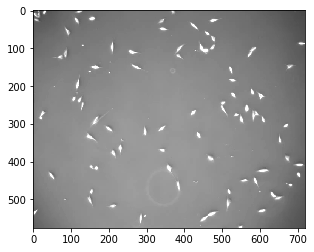

In [6]:
img=cv2.imread(path+'000.tif',cv2.IMREAD_COLOR)
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(gray,'gray')

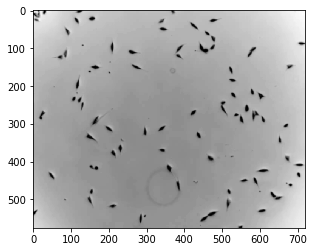

In [7]:
gray1=cv2.GaussianBlur(gray,(3,3),0)
gray1=cv2.GaussianBlur(gray1,(3,3),0)
gray2=255-gray1
plt.imshow(gray2,'gray')

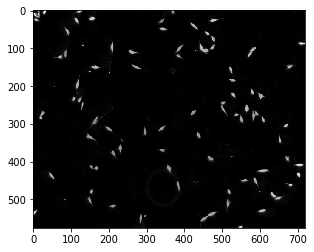

In [8]:
N=27
m=N//2
imgA=min_filter(gray,N,m)
imgB=max_filter(imgA,N,m)
imgO=subtract_img(img,imgB)
plt.imshow(imgO)

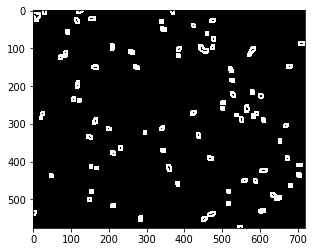

In [9]:
#腐蚀，膨胀
imgO_1=cv2.cvtColor(imgO,cv2.COLOR_BGR2GRAY)
ret0,thresh0 = cv2.threshold(imgO_1,0,255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh0,cv2.MORPH_OPEN,kernel, iterations = 2)
sure_bg = cv2.dilate(opening,kernel,iterations=3)
dist_transform = cv2.distanceTransform(sure_bg,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
plt.imshow(unknown,'gray')

In [10]:
# 细胞连在一起的处理
d,contours,hirearchy=cv2.findContours(unknown, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#找出连通域
#通过对连通域面积进行比较
contours1=[] 
for i in contours:
     if cv2.contourArea(i)>25:  #去除面积小的连通域
        contours1.append(i)
print(len(contours1)-1)

84


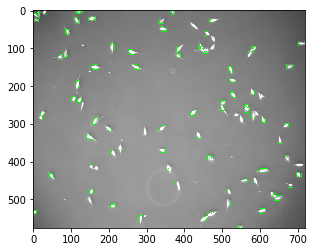

In [11]:
draw=cv2.drawContours(img,contours1,-1,(0,255,0),1)
plt.imshow(draw,'gray')

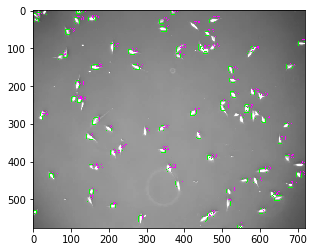

In [12]:
for i,j in zip(contours1,range(len(contours1))):
    M = cv2.moments(i)
    cX=int(M["m10"]/M["m00"])
    cY=int(M["m01"]/M["m00"])
    draw1=cv2.putText(draw, str(j), (cX, cY), 1,1, (255, 0, 255), 1)
plt.imshow(draw1,'gray')
plt.imsave('cell1.jpg',draw1)